In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
import torch
import torchvision
import sys
sys.path.append("../codes")

import PIL
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt

from dataset import BengalDfDataset, BengalImgDataset, load_pickle_images


In [2]:
data_folder =  "../data"
img_shape = (137, 236)

In [3]:
import os
for dirname, _, filenames in os.walk(data_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/class_map.csv
../data/sample_submission.csv
../data/test.csv
../data/train.csv
../data/test_image_data_0.parquet
../data/test_image_data_1.parquet
../data/test_image_data_2.parquet
../data/test_image_data_3.parquet
../data/train_image_data_0.parquet
../data/train_image_data_1.parquet
../data/train_image_data_2.parquet
../data/train_image_data_3.parquet
../data/train_data_0.pkl
../data/train_data_1.pkl
../data/train_data_2.pkl
../data/train_data_3.pkl
../data/cropped_imgs.pkl


In [5]:
train_df = pd.read_csv(os.path.join(data_folder, 'train.csv'))
test_df = pd.read_csv(os.path.join(data_folder, 'test.csv'))
class_map_df = pd.read_csv(os.path.join(data_folder, 'class_map.csv'))
sample_sub_df = pd.read_csv(os.path.join(data_folder, 'sample_submission.csv'))

In [23]:
sample_sub_df.head()

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,0
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,0


In [6]:
print(f'Size of training data: {train_df.shape}')
print(f'Size of test data: {test_df.shape}')
print(f'Size of class map: {class_map_df.shape}')

Size of training data: (200840, 5)
Size of test data: (36, 3)
Size of class map: (186, 3)


In [7]:
train_df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [8]:
test_df.head()

,row_id,image_id,component
0,Test_0_consonant_diacritic,Test_0,consonant_diacritic
1,Test_0_grapheme_root,Test_0,grapheme_root
2,Test_0_vowel_diacritic,Test_0,vowel_diacritic
3,Test_1_consonant_diacritic,Test_1,consonant_diacritic
4,Test_1_grapheme_root,Test_1,grapheme_root


In [9]:
# 各ラベルがどんな形を示すか
class_map_df.head()

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


### read parquet files

In [17]:
train_parquet_files = []
for i in range(4):
    train_parquet_files.append(pd.read_parquet(os.path.join(data_folder,'train_image_data_{}.parquet'.format(i))))


In [12]:
train_parquet_files[0].head()

,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,...,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,...,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,255,255,255,255


In [19]:
train_parquet_all = pd.concat(train_parquet_files, ignore_index=True)

In [21]:
train_all = train_parquet_all.merge(train_df, on="image_id")
train_all.shape, train_df.shape

((200840, 32337), (200840, 5))

In [22]:
train_all.head()

,image_id,0,1,2,3,4,5,6,7,8,...,32326,32327,32328,32329,32330,32331,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,251,15,9,5,ক্ট্রো
1,Train_1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,254,159,0,0,হ
2,Train_2,251,250,249,250,249,245,247,252,252,...,253,253,253,253,251,249,22,3,5,খ্রী
3,Train_3,247,247,249,253,253,252,251,251,250,...,254,253,253,252,251,252,53,2,2,র্টি
4,Train_4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,71,9,5,থ্রো


### show image examples

<Figure size 432x288 with 0 Axes>

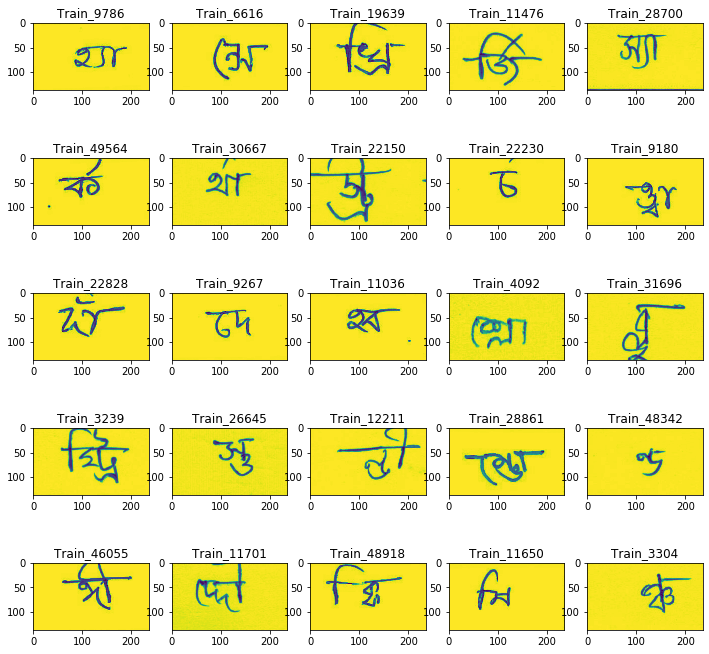

In [15]:
def display_image_from_data(data_df, size=5):
    '''
    Display grapheme images from sample data
    param: data_df - sample of data
    param: size - sqrt(sample size of data)
    '''
    plt.figure()
    fig, ax = plt.subplots(size,size,figsize=(12,12))
    # we show grapheme images for a selection of size x size samples
    for i, index in enumerate(data_df.index):
        image_id = data_df.iloc[i]['image_id']
        flattened_image = data_df.iloc[i].drop('image_id').values.astype(np.uint8)
        unpacked_image = PIL.Image.fromarray(flattened_image.reshape(137, 236))

        ax[i//size, i%size].imshow(unpacked_image)
        ax[i//size, i%size].set_title(image_id)
        ax[i//size, i%size].axis('on')

display_image_from_data(train_parquet_files[0].sample(25))


In [22]:
transform_ = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(mode=None),
#                                                                                 torchvision.transforms.RandomRotation(degrees=10,),
                                                                                 torchvision.transforms.RandomAffine(degrees=5, translate=(0.01, 0.01), scale=(0.8, 1.2), shear=None, resample=False, fillcolor=0),
#                                                                                  torchvision.transforms.ToTensor(),
                                                                                ])


In [4]:
cropped_imgs = np.asarray(pd.read_pickle("../data/cropped_imgs.pkl"))


In [51]:
np.tile(cropped_imgs[:5], (1, 1,1, 3)).shape

(5, 128, 128, 3)

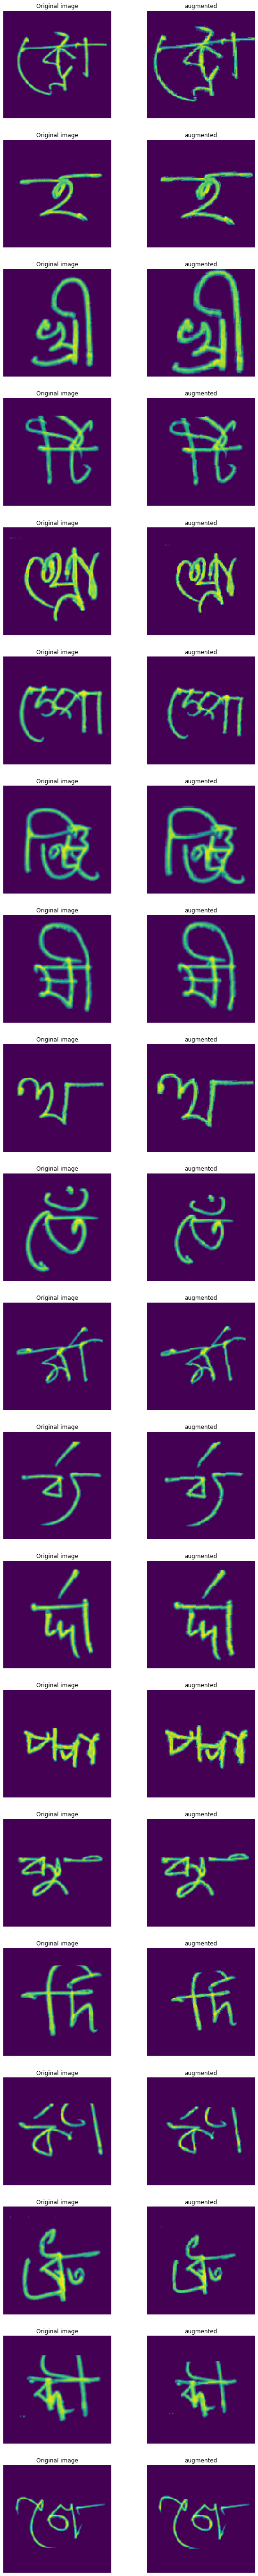

In [23]:
# img = transform_(cropped_imgs[0])
# fig = plt.figure()
# plt.imshow(img)
# img[0].size()

n_imgs = 20
fig, axs = plt.subplots(n_imgs, 2, figsize=(10, 5*n_imgs))

for idx in range(n_imgs):
    #somehow the original input is inverted
    img = cropped_imgs[idx]
    img0 = transform_(img)
    
    axs[idx,0].imshow(np.array(img)[:, :, 0])
    axs[idx,0].set_title('Original image')
    axs[idx,0].axis('off')
    axs[idx,1].imshow(np.array(img0))
    axs[idx,1].set_title('augmented')
    axs[idx,1].axis('off')
plt.show()

### Image preprocessing (128x128)
https://www.kaggle.com/iafoss/image-preprocessing-128x128

In [26]:
import cv2
from tqdm import tqdm_notebook as tqdm
import zipfile
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
HEIGHT = 137
WIDTH = 236
SIZE = 128

In [2]:
# !pip install opencv-python

In [24]:
imgs, vowels, graphemes, consonants = load_pickle_images()


In [27]:
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=SIZE, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 10] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))

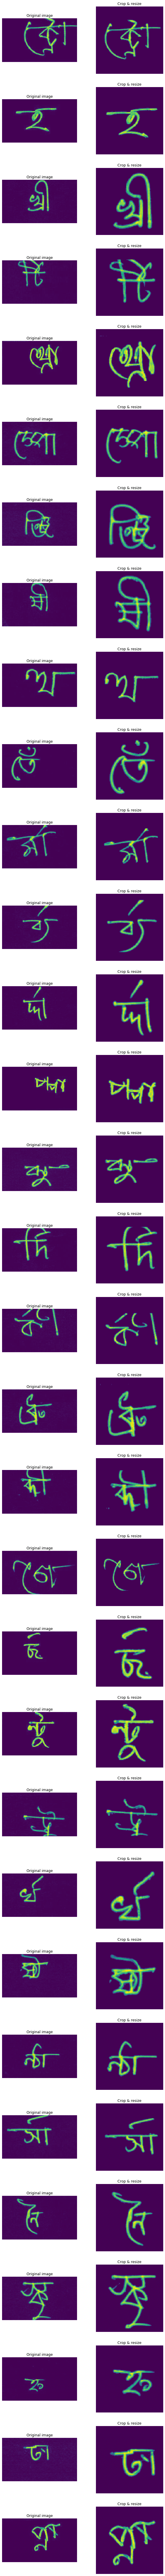

In [7]:
# show cropped examples.
n_imgs = 32
fig, axs = plt.subplots(n_imgs, 2, figsize=(10, 5*n_imgs))

for idx in range(n_imgs):
    #somehow the original input is inverted
    img0 = 255 - imgs[idx]
    img0 = img0.reshape([HEIGHT, WIDTH])
    
    #normalize each image by its max val
    img = (img0*(255.0/img0.max())).astype(np.uint8)
    img = crop_resize(img)

    axs[idx,0].imshow(img0)
    axs[idx,0].set_title('Original image')
    axs[idx,0].axis('off')
    axs[idx,1].imshow(img)
    axs[idx,1].set_title('Crop & resize')
    axs[idx,1].axis('off')
plt.show()

In [8]:
# save images
cropped_imgs = []
for idx in tqdm(range(len(imgs))):
    img = imgs[idx]
    #somehow the original input is inverted
    img0 = 255 - imgs[idx]
    img0 = img0.reshape([HEIGHT, WIDTH])
    
    #normalize each image by its max val
    img1 = (img0*(255.0/img0.max())).astype(np.uint8)
    img1 = crop_resize(img1)
    img1 = img1.reshape([SIZE, SIZE, 1])
    cropped_imgs.append(img1)

In [15]:
import collections
collections.Counter(img1.flatten())

Counter({0: 14238,
         24: 11,
         32: 9,
         42: 11,
         47: 8,
         52: 11,
         54: 9,
         56: 4,
         55: 4,
         50: 10,
         41: 6,
         37: 12,
         33: 13,
         23: 9,
         15: 13,
         20: 16,
         43: 4,
         68: 9,
         87: 7,
         107: 8,
         125: 8,
         133: 13,
         138: 10,
         140: 9,
         132: 5,
         123: 8,
         126: 6,
         118: 6,
         101: 8,
         95: 7,
         81: 6,
         19: 10,
         66: 9,
         74: 6,
         92: 5,
         113: 4,
         136: 11,
         152: 11,
         159: 16,
         165: 11,
         175: 18,
         182: 9,
         180: 9,
         179: 16,
         189: 9,
         190: 15,
         181: 8,
         184: 10,
         172: 15,
         170: 6,
         161: 19,
         102: 6,
         58: 10,
         8: 21,
         6: 13,
         34: 10,
         46: 10,
         49: 8,
         61: 6,
  

In [10]:
pd.to_pickle(cropped_imgs, "../data/cropped_imgs.pkl")

In [8]:
cropped_imgs = np.asarray(pd.read_pickle("../data/cropped_imgs.pkl"))

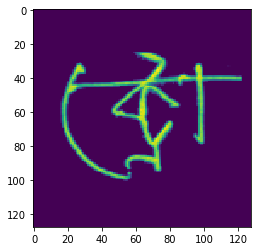

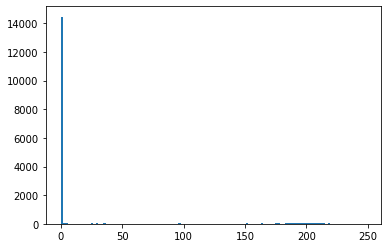

In [17]:
for img in cropped_imgs:
    plt.imshow(img[:,:,0])
    break
    
fig = plt.figure()
plt.hist(img[:,:,0].flatten(), bins=122)
plt.show()

In [ ]:
#image stats
pixels = []
for img in cropped_imgs[:30000]:
    pixels.extend(img.flatten()/255)

In [ ]:
avg = np.mean(pixels)
std = np.std(pixels)
print("Aerage: ", avg)
print("Std: ", std)